# Load data

In [7]:
# load all the different libraries required
import numpy as np
import pandas as pd
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import explained_variance_score
from scipy.stats import linregress
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import AdaBoostRegressor
from sklearn.pipeline import Pipeline
from scipy.special import inv_boxcox
import math
import xgboost as xgb
import random
import matplotlib.pyplot as plt
import pandas as pd
import sys
import shap
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from scipy import stats
from sklearn.svm import SVR
from sklearn.model_selection import cross_validate

# set the grip in darkmode for plots
sns.set_style("darkgrid")

# print current position of the file
print(xgb.__file__)

C:\Users\barakat\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\__init__.py


In [8]:
# load data and their shape
df_dmpfc = pd.read_excel('D:\python_work\python_exp1\datasets\met_dmpfc_imputed.xlsx', index_col=None,header=None)  
met_dmpfc = df_dmpfc.values
print(np.shape(met_dmpfc))

df_ai = pd.read_excel('D:\python_work\python_exp1\datasets\met_ai_imputed.xlsx', index_col=None,header=None)  
met_ai = df_ai.values
print(np.shape(met_ai))


df_mod = pd.read_excel('D:\python_work\python_exp1\datasets\corr_mod_bias.xlsx', index_col=None,header=None)  
mod = df_mod.values
print(np.shape(mod))

df_perf = pd.read_excel('D:\python_work\python_exp1\datasets\perf_data.xlsx', index_col=None,header=None,sheet_name ="filtered_data")  
perf = df_perf.values
print(np.shape(perf))

# current label order :
met_label=['Asp', 'GABA', 'Gln', 'Glu', 'GSH', 'Gly', 'Ins', 'Lac', 'NAA','Glx','PCr+Cr','Gln/Glu','Glu/GABA']

(75, 13)
(75, 13)
(75, 7)
(75, 16)


## Prepare dataset in function of missing data

In [9]:
# find and remove data where there is no label measures, as for ML you need filled dataset.
# For research papers, filling datasets is not accepted, so drop the current data.
missing_data_kEm_idx = np.isnan(mod[:,3])
missing_data_kFm_idx = np.isnan(mod[:,6])
missing_data_kEp_idx = np.isnan(mod[:,2])
missing_data_kFp_idx = np.isnan(mod[:,5])
missing_data_kR_idx = np.isnan(mod[:,0])
missing_data_kP_idx = np.isnan(mod[:,1])
missing_data_bias_idx = np.isnan(mod[:,4])
missing_data_PHE_idx = np.isnan(perf[:,2])
missing_data_MHE_idx = np.isnan(perf[:,3])

# now use the index to remove the line where there is a missing label
met_dmpfc_kEm_clean = np.delete(met_dmpfc,missing_data_kEm_idx, axis=0)
met_dmpfc_kFm_clean = np.delete(met_dmpfc,missing_data_kFm_idx, axis=0)
met_dmpfc_kEp_clean = np.delete(met_dmpfc,missing_data_kEp_idx, axis=0)
met_dmpfc_kFp_clean = np.delete(met_dmpfc,missing_data_kFp_idx, axis=0)
met_dmpfc_kR_clean = np.delete(met_dmpfc,missing_data_kR_idx, axis=0)
met_dmpfc_kP_clean = np.delete(met_dmpfc,missing_data_kP_idx, axis=0)
met_dmpfc_bias_clean = np.delete(met_dmpfc,missing_data_bias_idx, axis=0)
met_dmpfc_MHE_clean = np.delete(met_dmpfc,missing_data_MHE_idx, axis=0)
met_dmpfc_PHE_clean = np.delete(met_dmpfc,missing_data_PHE_idx, axis=0)
met_ai_kEm_clean = np.delete(met_ai,missing_data_kEm_idx, axis=0)
met_ai_kFm_clean = np.delete(met_ai,missing_data_kFm_idx, axis=0)
met_ai_kEp_clean = np.delete(met_ai,missing_data_kEp_idx, axis=0)
met_ai_kFp_clean = np.delete(met_ai,missing_data_kFp_idx, axis=0)
met_ai_kR_clean = np.delete(met_ai,missing_data_kR_idx, axis=0)
met_ai_kP_clean = np.delete(met_ai,missing_data_kP_idx, axis=0)
met_ai_bias_clean = np.delete(met_ai,missing_data_bias_idx, axis=0)
met_ai_MHE_clean = np.delete(met_ai,missing_data_MHE_idx, axis=0)
met_ai_PHE_clean = np.delete(met_ai,missing_data_PHE_idx, axis=0)
mod_kEm = np.delete(mod[:,3],missing_data_kEm_idx,axis=0)
mod_kFm = np.delete(mod[:,6],missing_data_kFm_idx, axis=0)
mod_kEp = np.delete(mod[:,2],missing_data_kEp_idx,axis=0)
mod_kFp = np.delete(mod[:,5],missing_data_kFp_idx, axis=0)
mod_kR = np.delete(mod[:,0],missing_data_kR_idx, axis=0)
mod_kP = np.delete(mod[:,1],missing_data_kP_idx, axis=0)
mod_bias = np.delete(mod[:,4],missing_data_bias_idx, axis=0)
PHE = np.delete(perf[:,2],missing_data_PHE_idx, axis=0)
MHE = np.delete(perf[:,3],missing_data_MHE_idx, axis=0)

## Zscore data

In [10]:
#""" in case you need to zscore the datasets
met_dmpfc = stats.zscore(met_dmpfc,axis=0, ddof=1)
met_dmpfc_kEm_clean =  stats.zscore(met_dmpfc_kEm_clean,axis=0, ddof=1)
met_dmpfc_kFm_clean = stats.zscore(met_dmpfc_kFm_clean,axis=0, ddof=1)
met_dmpfc_kEp_clean =  stats.zscore(met_dmpfc_kEp_clean,axis=0, ddof=1)
met_dmpfc_kFp_clean =  stats.zscore(met_dmpfc_kFp_clean,axis=0, ddof=1)
met_dmpfc_kR_clean = stats.zscore(met_dmpfc_kR_clean,axis=0, ddof=1)
met_dmpfc_kP_clean =  stats.zscore(met_dmpfc_kP_clean,axis=0, ddof=1)
met_dmpfc_bias_clean = stats.zscore(met_dmpfc_bias_clean,axis=0, ddof=1)
met_dmpfc_MHE_clean =  stats.zscore(met_dmpfc_MHE_clean,axis=0, ddof=1)
met_dmpfc_PHE_clean =  stats.zscore(met_dmpfc_PHE_clean,axis=0, ddof=1)
met_ai_kEm_clean =  stats.zscore(met_ai_kEm_clean,axis=0, ddof=1)
met_ai_kFm_clean = stats.zscore(met_ai_kFm_clean,axis=0, ddof=1)
met_ai_kEp_clean =  stats.zscore(met_ai_kEp_clean,axis=0, ddof=1)
met_ai_kFp_clean =  stats.zscore(met_ai_kFp_clean,axis=0, ddof=1)
met_ai_kR_clean = stats.zscore(met_ai_kR_clean,axis=0, ddof=1)
met_ai_kP_clean =  stats.zscore(met_ai_kP_clean,axis=0, ddof=1)
met_ai_bias_clean = stats.zscore(met_ai_bias_clean,axis=0, ddof=1)
met_ai_MHE_clean =  stats.zscore(met_ai_MHE_clean,axis=0, ddof=1)
met_ai_PHE_clean =  stats.zscore(met_ai_PHE_clean,axis=0, ddof=1)
met_ai = stats.zscore(met_ai,axis=0, ddof=1)
#"""

## Skewness correction

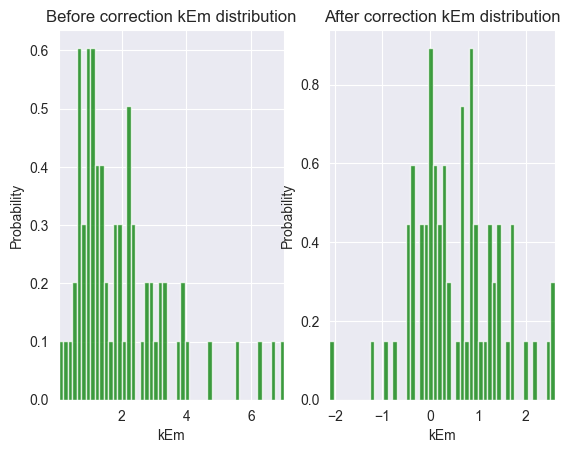

lambda for the corrections are : 0.28619029483596764


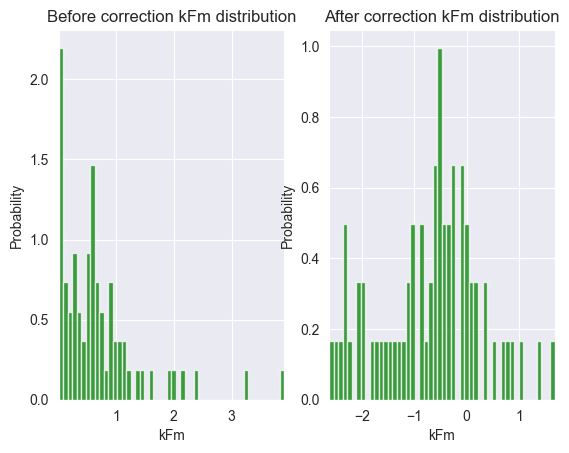

lambda for the corrections are : 0.2991546270757369


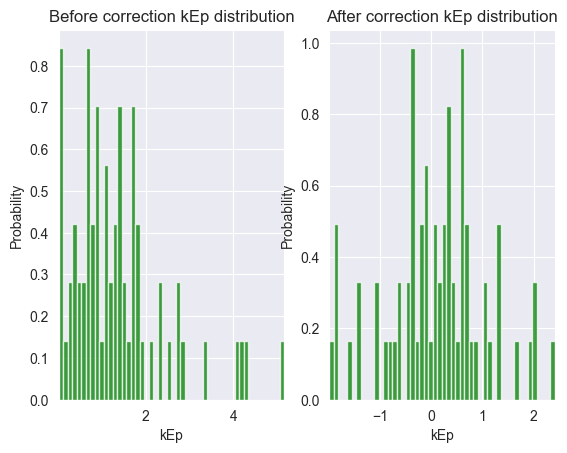

lambda for the corrections are : 0.4418333232697921


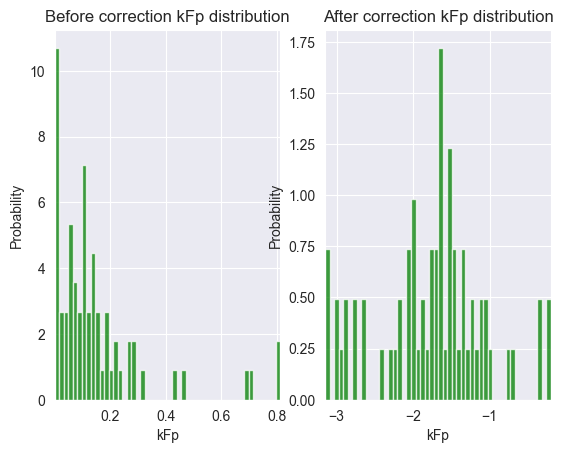

lambda for the corrections are : 0.2689558421921443


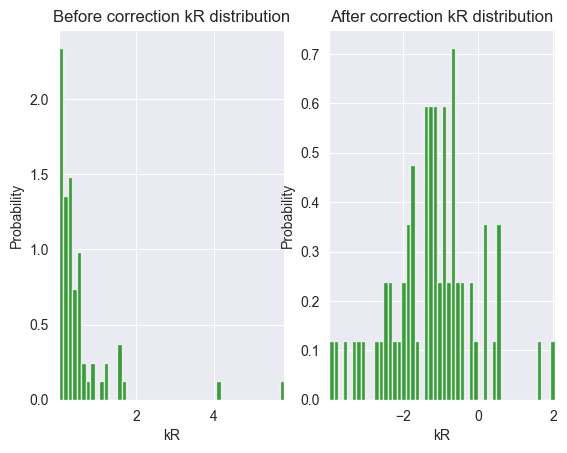

lambda for the corrections are : 0.1638103856231294


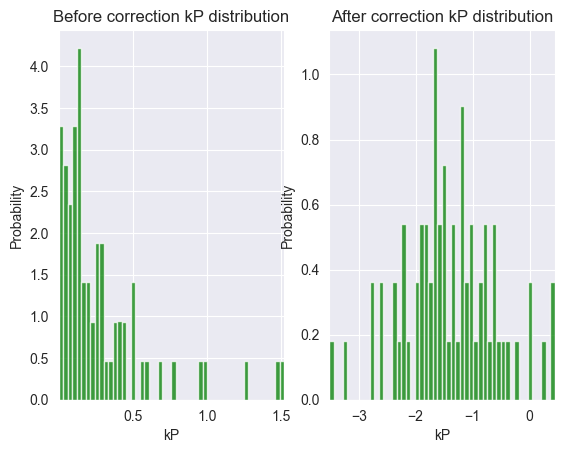

lambda for the corrections are : 0.23108529460703567


In [11]:
# ML is sensitive to data distribution, you can correct skewness if needed
def skewness_correction(data,data_name):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    plt.subplot(1, 2, 1)
    # look at label distribution
    n, bins, patches = plt.hist(data, 50, density=True, facecolor='g', alpha=0.75)
    plt.xlabel(data_name)
    plt.ylabel('Probability')
    plt.title('Before correction '+data_name+' distribution')
    plt.xlim(np.min(data), np.max(data))
    plt.grid(True)

    plt.subplot(1, 2, 2)
    # plot label after boxcox transformation
    data, lambda_ = stats.boxcox(data)
    n, bins, patches = plt.hist(data, 50, density=True, facecolor='g', alpha=0.75)
    plt.xlabel(data_name)
    plt.ylabel('Probability')
    plt.title('After correction '+ data_name +' distribution')
    plt.xlim(np.min(data), np.max(data))
    plt.grid(True)
    plt.show()
    print("lambda for the corrections are : {}".format(lambda_))

    return data,lambda_

# plot and correct the distributions
mod_kEm,lambda_ = skewness_correction(mod_kEm,'kEm')
mod_kFm,lambda_ = skewness_correction(mod_kFm,'kFm')
mod_kEp,lambda_ = skewness_correction(mod_kEp,'kEp')
mod_kFp,lambda_ = skewness_correction(mod_kFp,'kFp')
mod_kR,lambda_ = skewness_correction(mod_kR,'kR')
mod_kP,lambda_ = skewness_correction(mod_kP,'kP')


## Functions to apply xgboost

In [7]:
# first round of feature removal, remove anything with a pearson corr underneath 0.1
def corr(x,y,x_name,y_name):
    r = np.zeros((len(y),1))
    p = np.zeros((len(y),1))
    feat_to_keep = list()
    nb_feat = np.shape(x)[1]
    # for each feature, keep only if the score is higher than 0.1
    for i in range(0,nb_feat):    
        r[i], p[i] = stats.pearsonr(x[:,i],y)
        if np.abs(r[i]) > 0.1:
            feat_to_keep.append(i)
        
        print("for feat {}, r = {}, p = {}".format(x_name[i],r[i],p[i]))
    return feat_to_keep

In [8]:
# With cross validation, initiate param with a set of hyperparam and run LOOCV. print parameters used, and select the best accordingly
def objective_with_cv(space):
    # hyperparameters of gxboost we would like to optimize
    params = {'eval_metric': 'rmse',
              'learning_rate': space['learning_rate'],
              'max_depth': int(space['max_depth']),
              'min_child_weight': space['min_child_weight'],
              'gamma': space['gamma'],
              'reg_lambda': space['reg_lambda'],
              'reg_alpha': space['reg_alpha'],
              'n_jobs': -1} # n jobs make parallel runs, max the power used by the cpu

    cv_result = xgb.cv(params, dtrain,num_boost_round=100, nfold=nfold_LOO,early_stopping_rounds=5)
    return {'loss':cv_result['test-rmse-mean'].iloc[-1], 'status': STATUS_OK }

# Train an xgboost model and print RMSE using hyperopt package
def find_optimal_hyperparam(space,seed): 
    
    trials = Trials()
    # best returns the optimal hyperparameters
    best = fmin(fn=objective_with_cv,
            space=space,
            algo=tpe.suggest,
            max_evals=10,
            trials=trials,
            rstate=np.random.default_rng(seed=seed))
    return best,np.min(trials.losses())

In [9]:
# Function to train an xgboost model and print RMSE
def xgb_train(params,dtrain,dtest,steps,label_val,print_RMSE): 
    model = xgb.train(params=params, dtrain=dtrain, num_boost_round=steps)
    preds = np.array(model.predict(dtest))
    
    # Calculate the Root Mean Squared Error, the metric of accuracy
    RMSE = math.sqrt(np.mean((preds - label_val) ** 2))
    
    if print_RMSE == True:
        print("RMSE: %.10f"
              % RMSE)

    return RMSE

In [10]:
# this function tests whether or not or prediction accuracy is by chance
def significance_permutation_test(ML_type,param,steps,label,data,TRUERMSE,seed,test_size,plot_save_name,nb_of_permutation=5000):
    
    RMSERand = np.empty(nb_of_permutation)
    
    print("\n Will now run permutation test, to check for significance, please wait:")
    rand_labels = np.zeros((nb_of_permutation,len(label)))
    for rand in range(nb_of_permutation):
        rand_label = np.random.permutation(label)
        
        if ML_type =='xgb':
            # split data.
            data_train_val, data_test, rand_label_train_val, rand_label_test = train_test_split(data, rand_label, test_size=test_size, random_state=seed)
            dtrain = xgb.DMatrix(data_train_val, label=rand_label_train_val)
            dtest = xgb.DMatrix(data_test, label=rand_label_test)
    
            # compute RMSE with shuffled labels.
            RMSERand[rand] = float(xgb_train(param,dtrain,dtest,steps,rand_label_test,print_RMSE=False))
                
        else:
            # this function can be used with several ML algorithm, you can add here the part specific about your model
            print('did not define the function for this ML model yet')
            break
            
        if ((rand % 1000) == 0 and (rand != 0)):
            print("running permutation number : {}, out of {}".format(rand,nb_of_permutation))
    
    # Compute 5 and 95 percentile which is similar to the alpha = 0.05
    limit1 = np.percentile(RMSERand,5)
    limit2 =np.percentile(RMSERand,95)

    # plot results
    n, bins, patches = plt.hist(RMSERand,50, density=True, ec= 'black',color ='#7931b0')

    plt.xlabel('Random RMSE')
    plt.ylabel('Probability')
    plt.title('Histogram of RMSE distribution for random label')
    plt.xlim(np.min(RMSERand), np.max(RMSERand))
    plt.grid(True)
    plt.axvline(limit1, color='black', linestyle= '--', linewidth=3)
    plt.axvline(TRUERMSE, color='r', linestyle='solid', linewidth=3)
    plt.legend(['95 percentile','True RMSE','RMSE rand perm',])
    plt.savefig(plot_save_name+'permut_test.svg',bbox_inches="tight")
    plt.show()
    
    # say if the model is significant
    if TRUERMSE < limit1:
        print("\033[1m" + "\n MODEL ACHIEVED SIGNIFICANCE" + "\033[0m")
        print(" True RMSE: {} < 5th percentile: {}< 95th percentile: {}|".format(TRUERMSE,limit1,limit2),sep = '\n\n')  
    else:
        print("\n Model is " + "\033[1m" + "NOT" + "\033[0m"+" significant")
        print(" 5th percentile: {} < True RMSE: {} < 95th percentile: {}|".format(limit1,TRUERMSE,limit2),sep = '\n\n')  



In [11]:
# Compute shap plot, by training the model and using shap package
def shap_plot(param,label,data,test_size,seed,feat_name,plot_save_name,nb_of_disp_param=15):

    # split data
    data_train_val, data_test, label_train_val, label_test = train_test_split(data,label, test_size=test_size, random_state=seed)
    dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
    dtest = xgb.DMatrix(data_test, label=label_test)
    model = xgb.train(param, dtrain,steps)
    preds = np.array(model.predict(dtest))

    # explain the model's predictions using SHAP values
    explainer = shap.TreeExplainer(model)
    shap_values_train = explainer.shap_values(data_train_val)
    r, p, lo, hi = pearsonr_ci(shap_values_train[:,0],shap_values_train[:,1],0.05)
    print("Correlation between first and second shap score features, r = {}. p = {}".format(r,p),sep = '\n\n')
    
    # summarize the effects of all the features
    shap.summary_plot(shap_values_train, data_train_val,feature_names = feat_name, max_display = nb_of_disp_param,show=False)
    plt.savefig(plot_save_name+'_shap_plot.svg',bbox_inches="tight")
    plt.show()
    
    # plot the barplot of shap
    from matplotlib.colors import LinearSegmentedColormap
    newCmap = LinearSegmentedColormap.from_list("", ['#c4cfd4','#3345ea'])
    shap.summary_plot(shap_values_train, data_train_val, plot_type="bar", feature_names = feat_name, max_display = nb_of_disp_param,show=False, cmap=newCmap)  
    plt.savefig(plot_save_name+'_shap_feat_importance.svg',bbox_inches="tight")
    plt.show()
    

In [12]:
# Second round of feature reduction, through a LOOCV validation and training of a tree model
def feature_selection_CV(data_train_val,label_train_val,feat_names,k_fold,seed):
    
    # define number of features to evaluate, doesn't make sens to keep less
    min_nb_feat = 3
    num_features = [i for i in range(min_nb_feat, data_train_val.shape[1]+1)]
    # enumerate each number of features
    results = list()
    best_results_score = list()
    for k in num_features:
        print(k)
        model =AdaBoostRegressor(random_state=seed, n_estimators=100)
        fs = SelectKBest(score_func=f_regression, k=k)
        
        # learn relationship from training data
        fs.fit(data_train_val, label_train_val)
        print(fs.get_feature_names_out(input_features=feat_names))
        pipeline = Pipeline(steps=[('sel',fs), ('lr', model)])
        
        # evaluate the model
        cv = KFold(n_splits=k_fold)
        scores = cross_val_score(pipeline, data_train_val, label_train_val, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1)
        results.append(scores)
        best_results_score.append(np.mean(scores))
        
        # summarize the results
        print('>%d %.3f (%.3f)' % (k, np.mean(scores), np.std(scores)))
        
    # plot model performance for comparison
    plt.boxplot(results, labels=num_features, showmeans=True)
    plt.show()
    # plot the scores
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    
    # take into account that idx starts at 0
    keep_nb_feat =best_results_score.index(np.max(best_results_score))+min_nb_feat
    print(best_results_score,keep_nb_feat)
    
    #select how many features you want to keep
    fs = SelectKBest(score_func=f_regression, k=keep_nb_feat)
    
    # learn relationship from training data
    fs.fit(data_train_val, label_train_val)
    print(fs.get_feature_names_out(input_features=feat_names))
    selected_feature = list()
    for x_idx,x in enumerate(feat_names):
        if x in fs.get_feature_names_out(input_features=feat_names):
            selected_feature.append(x_idx)
    return selected_feature

In [13]:
# calculate Pearson correlation along with the confidence interval using scipy and numpy
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    lo_z, hi_z = r_z-z*se, r_z+z*se
    lo, hi = np.tanh((lo_z, hi_z))
    return r, p, lo, hi

## SCRIPT TO RUN using metabolites in the dmPFC as a source dataset

## XGBoost model using metabolites from the dmPFC to predict MHE

for feat Asp, r = [-0.32957455], p = [0.01400533]
for feat GABA, r = [-0.03549989], p = [0.79694086]
for feat Gln, r = [-0.15710736], p = [0.25199871]
for feat Glu, r = [-0.24046395], p = [0.07699134]
for feat GSH, r = [-0.20618273], p = [0.13097971]
for feat Gly, r = [0.07845424], p = [0.56912075]
for feat Ins, r = [-0.06942269], p = [0.61451774]
for feat Lac, r = [-0.16100087], p = [0.24028742]
for feat NAA, r = [-0.16520903], p = [0.22805477]
for feat Glx, r = [-0.24548143], p = [0.07084408]
for feat PCr+Cr, r = [-0.21666695], p = [0.11208839]
for feat Gln/Glu, r = [-0.07399752], p = [0.59132807]
for feat Glu/GABA, r = [0.01905577], p = [0.89017098]
selected feature by adaboost: [0, 2, 3, 4, 7, 8, 9, 10]
3
['Asp' 'Glu' 'Glx']
>3 -14.115 (11.880)
4
['Asp' 'Glu' 'Glx' 'PCr+Cr']
>4 -13.894 (12.146)
5
['Asp' 'Glu' 'GSH' 'Glx' 'PCr+Cr']
>5 -13.700 (12.499)
6
['Asp' 'Glu' 'GSH' 'NAA' 'Glx' 'PCr+Cr']
>6 -14.349 (12.012)
7
['Asp' 'Glu' 'GSH' 'Lac' 'NAA' 'Glx' 'PCr+Cr']
>7 -13.994 (12.179)
8

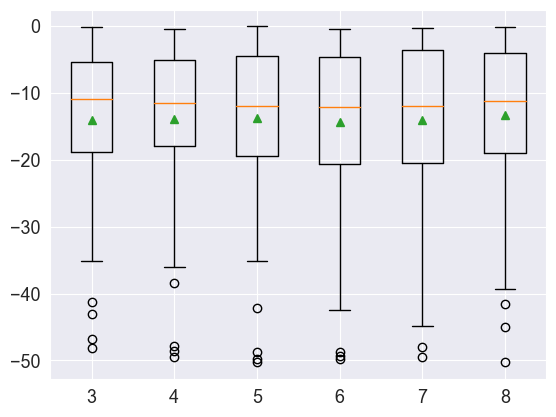

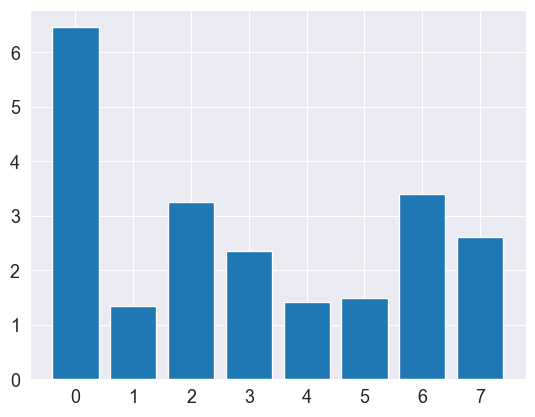

[-14.115089889364691, -13.894311092912876, -13.699555595729384, -14.348570198733256, -13.994050201014165, -13.267577828750394] 8
['Asp' 'Gln' 'Glu' 'GSH' 'Lac' 'NAA' 'Glx' 'PCr+Cr']
selected feature by adaboost: [0, 1, 2, 3, 4, 5, 6, 7]
100%|████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.26s/trial, best loss: 13.046768895353678]

 Optimal selected parameters are : 
 {'eta': 0.2740792746355464, 'max_depth': 35, 'min_child_weight': 0.03331121071573893, 'gamma': 0.009824583937627196, 'lambda': 0.05295931819258426, 'alpha': 0.03922147751083208, 'tree_method': 'exact', 'booster': 'gbtree'} 

[69.90568  69.55303  75.74463  68.26521  64.57304  79.07739  84.41195
 85.76296  82.27441  72.161835 79.62622  84.031425 78.33062  79.45714 ]
Train RMSE : 0.04857388047024451
Val RMSE : 13.046768895353678
TRUE RMSE: 12.51382

 r value :  0.4994502472224331 


 R2 value :  0.24945054945054954 


 p value :  0.034504408972321855 

Label range: 67.59259
RMSE Percentage Error: 18.5

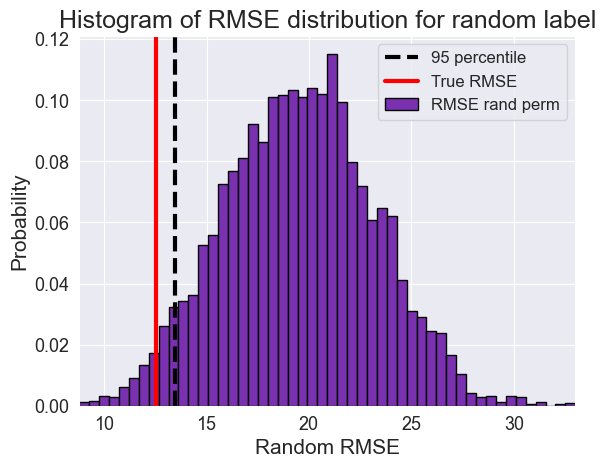


 MODEL ACHIEVED SIGNIFICANCE
 True RMSE: 12.51381511505876 < 5th percentile: 13.468116303701681< 95th percentile: 25.641374543357195|
Correlation between first and second shap score features, r = 0.3224012542705371. p = 0.01637009906262492


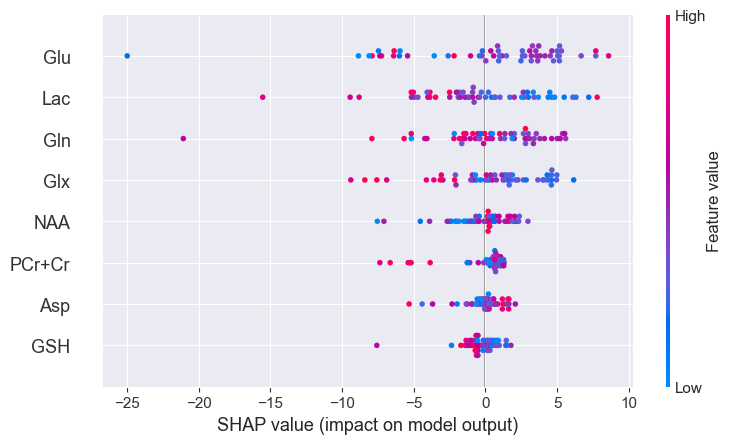

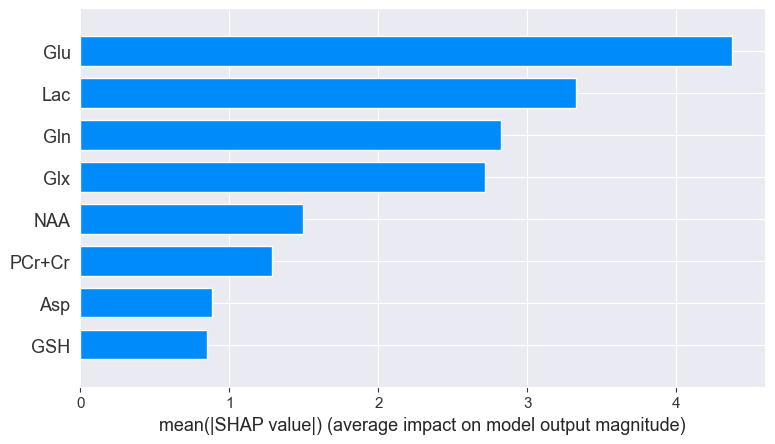

In [14]:
# define parameters range
seed =3
test_size = 0.2
steps = 100

## initiate dataset and label
label = 100*MHE/54
data = met_dmpfc_MHE_clean
label_name = 'MHE'
data_names = met_label
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels

# split data into train and test sets
data_train_val, data_test, label_train_val, label_test = train_test_split(data, label, test_size=test_size, random_state=seed)

# first remove any feat with a corr smaller than 0.1

feat_to_keep_wo_low_corr = corr(data_train_val,label_train_val,met_label,label_name)
print("selected feature by adaboost: {}".format(feat_to_keep_wo_low_corr))
data = data[:,feat_to_keep_wo_low_corr]
data_train_val = data_train_val[:,feat_to_keep_wo_low_corr]
data_test = data_test[:,feat_to_keep_wo_low_corr]
data_names = np.array(data_names)[feat_to_keep_wo_low_corr]
nfold_LOO = len(label_train_val)

# next check which feature to keep with adaboost.
selected_feature = feature_selection_CV(data_train_val,label_train_val,feat_names= data_names,k_fold=nfold_LOO,seed=seed)
print("selected feature by adaboost: {}".format(selected_feature))
data = data[:,selected_feature]
data_train_val = data_train_val[:,selected_feature]
data_test = data_test[:,selected_feature]
data_names = np.array(data_names)[selected_feature]


# prepare xgboost format after feature selection.
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)

# initialize the range to test with hyperopt
space ={'learning_rate' : hp.uniform('x_eta', 0.01,0.3),
        'max_depth': hp.uniform("x_max_depth", 5,50),
        'min_child_weight': hp.uniform ('x_min_child', 0,0.2),
        'gamma' : hp.uniform ('x_gamma',0,0.2),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,0.06),
        'reg_alpha' : hp.uniform ('x_reg_alpha', 0,0.06)}



# find optimal hyperparameters through hyperopt extension
best,best_val_RMSE = find_optimal_hyperparam(space,seed)

# initialize optimal param

param = {'eta': best['x_eta'],
          'max_depth': int(best['x_max_depth']),
          'min_child_weight': best['x_min_child'],
          'gamma': best['x_gamma'],
          'lambda': best['x_reg_lambda'],
          'alpha': best['x_reg_alpha'],
          'tree_method' : 'exact',
          'booster': 'gbtree'}

# optimal hyperparameters are:
print("\n Optimal selected parameters are : \n {} \n".format(param), sep = '\n\n')


# quickly train the model with the hole dataset (not CV anymore)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)
model = xgb.train(param,dtrain, steps)
preds_train = np.array(model.predict(dtrain))
preds_test = np.array(model.predict(dtest))
print(preds_test)

# Calculate Train RMSE
print("Train RMSE : {}".format(math.sqrt(np.mean((preds_train - label_train_val) ** 2))))
print("Val RMSE : {}".format(best_val_RMSE))

# Calculate the Root Mean Squared Error
print("TRUE RMSE: %.5f"
      % math.sqrt(np.mean((preds_test - label_test) ** 2)), sep = '\n\n')
TRUERMSE = math.sqrt(np.mean((preds_test - label_test) ** 2))

r_value,p_value = stats.spearmanr(preds_test, label_test,alternative='greater')
print('\n r value : ',r_value,'\n')
print('\n R2 value : ',r_value*r_value,'\n')
print('\n p value : ',p_value,'\n')

print("Label range: %.5f"
        % float(max(label) - min(label)), sep = '\n\n')
label_range = float(max(label) - min(label))

print("RMSE Percentage Error: %.2f" % (100*(TRUERMSE/label_range))+ "%", sep = '\n\n')

# Check if the model is obtained by chance
significance_permutation_test(ML_type ='xgb',param=param,steps=steps,label=label,data=data,TRUERMSE=TRUERMSE,seed=seed,test_size=test_size,plot_save_name='dmpfc_'+label_name,nb_of_permutation=5000)

# look at the most important features
shap_plot(param,label,data,test_size,seed,feat_name=data_names,plot_save_name='dmpfc_'+label_name,nb_of_disp_param=np.size(selected_feature))

0.5425723446564769 0.04499867484774457


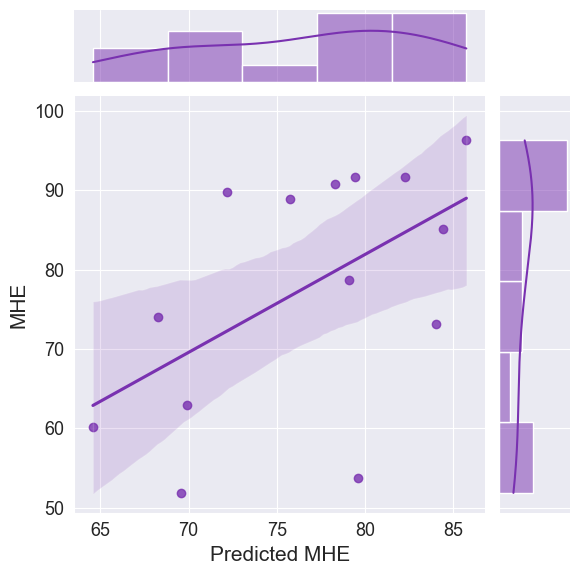

In [15]:
# predict MHE test and plot
df_plot = {'test_label': label_test, 'test_prediction': preds_test}
[label_test, preds_test]
sns.set_style("darkgrid")
plot = sns.jointplot(data=df_plot, x="test_prediction", y="test_label", kind="reg",color='#7931b0',marginal_kws={'color': '#7931b0', 'hist_kws': {'edgecolor': 'black'}})
plt.xlabel('Predicted MHE', fontsize=15)
plt.ylabel('MHE', fontsize=15)
plot.savefig('MHE_test_pred_label_corr_dmpfc.svg',bbox_inches="tight")
slope, intercept, r_value, p_value, std_err = linregress(preds_test, label_test)
print(r_value,p_value)

## XGBoost model using metabolites from the dmPFC to predict PHE

(69, 13)
(69, 13)
for feat Asp, r = [-0.03760009], p = [0.78520588]
for feat GABA, r = [0.21710026], p = [0.11135516]
for feat Gln, r = [-0.03889647], p = [0.77798572]
for feat Glu, r = [-0.00227298], p = [0.98685968]
for feat GSH, r = [-0.01296625], p = [0.92514453]
for feat Gly, r = [-0.16313725], p = [0.23402224]
for feat Ins, r = [-0.04977408], p = [0.71818938]
for feat Lac, r = [-0.21880917], p = [0.10849914]
for feat NAA, r = [0.06992362], p = [0.61195964]
for feat Glx, r = [-0.01741467], p = [0.89957859]
for feat PCr+Cr, r = [-0.0203457], p = [0.88278693]
for feat Gln/Glu, r = [-0.03928364], p = [0.77583294]
for feat Glu/GABA, r = [-0.19309149], p = [0.15781893]
selected feature by adaboost: [1, 5, 7, 12]
3
['GABA' 'Lac' 'Glu/GABA']
>3 -16.394 (10.619)
4
['GABA' 'Gly' 'Lac' 'Glu/GABA']
>4 -16.157 (9.048)


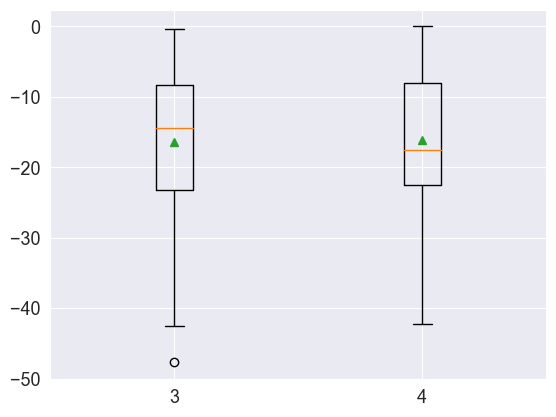

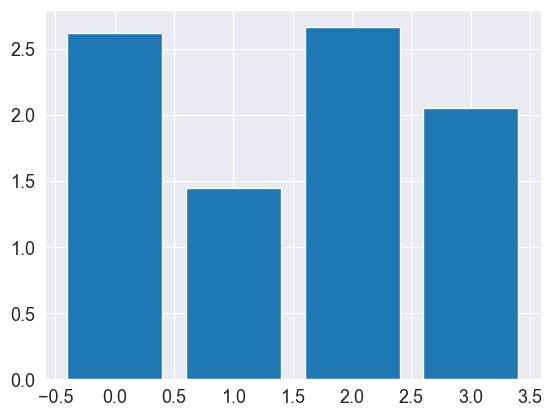

[-16.393592222966273, -16.15715805417139] 4
['GABA' 'Gly' 'Lac' 'Glu/GABA']
selected feature by adaboost: [0, 1, 2, 3]
100%|████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.74s/trial, best loss: 16.062069933891983]

 Optimal selected parameters are : 
 {'eta': 0.07361563171088928, 'max_depth': 39, 'min_child_weight': 0.24461567150301783, 'gamma': 0.053380938846081416, 'lambda': 0.1976772979946422, 'alpha': 0.14669723084571254, 'tree_method': 'exact', 'booster': 'gbtree'} 

[59.021923 55.76005  74.56047  54.62645  65.43852  60.37041  63.71677
 86.01832  60.739105 76.098045 56.051067 44.697945 49.88799  63.858753]
Train RMSE : 0.16900028159306246
Val RMSE : 16.062069933891983
TRUE RMSE: 23.00384

 r value :  0.015384615384615385 


 R2 value :  0.0002366863905325444 


 p value :  0.4791848946859931 

Label range: 86.11111
RMSE Percentage Error: 26.71%

 Will now run permutation test, to check for significance, please wait:
running permutation number : 1000, out o

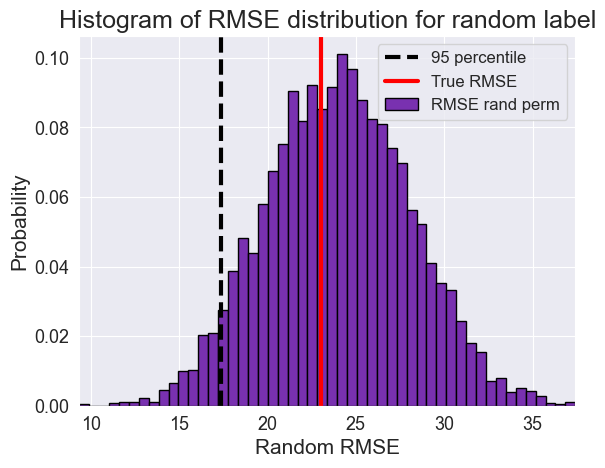


 Model is NOT significant
 5th percentile: 17.388379162392646 < True RMSE: 23.003837070506545 < 95th percentile: 30.697233687388632|
Correlation between first and second shap score features, r = 0.43795137090237474. p = 0.0008258860879287829


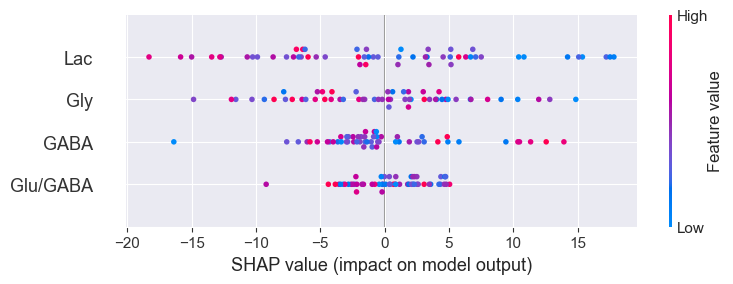

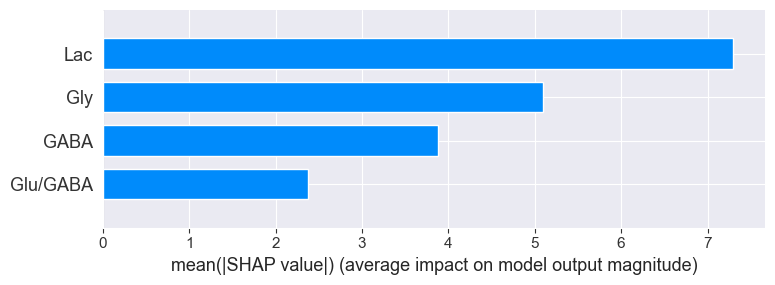

In [16]:
# define parameters range
seed =3
test_size = 0.2
steps = 100

## initiate dataset and label
label = 100*PHE/54
data = met_dmpfc_PHE_clean
print(np.shape(data))
# remove the PCr ratio as it might not be a stable measure according to experts
data = data[:,0:15]
print(np.shape(data))

label_name = 'HPE'
data_names = met_label
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels

# split data into train and test sets
data_train_val, data_test, label_train_val, label_test = train_test_split(data, label, test_size=test_size, random_state=seed)


# first remove any feat with a corr smaller than 0.1
feat_to_keep_wo_low_corr = corr(data_train_val,label_train_val,met_label,label_name)
print("selected feature by adaboost: {}".format(feat_to_keep_wo_low_corr))
data = data[:,feat_to_keep_wo_low_corr]
data_train_val = data_train_val[:,feat_to_keep_wo_low_corr]
data_test = data_test[:,feat_to_keep_wo_low_corr]
data_names = np.array(data_names)[feat_to_keep_wo_low_corr]
nfold_LOO = len(label_train_val)

# next check which feature to keep with adaboost.
selected_feature = feature_selection_CV(data_train_val,label_train_val,feat_names= data_names,k_fold=nfold_LOO,seed=seed)
print("selected feature by adaboost: {}".format(selected_feature))
data = data[:,selected_feature]
data_train_val = data_train_val[:,selected_feature]
data_test = data_test[:,selected_feature]
data_names = np.array(data_names)[selected_feature]


# prepare xgboost format after feature selection.
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)

# initialize the range to test with hyperopt
space ={'learning_rate' : hp.uniform('x_eta', 0.01,0.3),
        'max_depth': hp.uniform("x_max_depth", 5,50),
        'min_child_weight': hp.uniform ('x_min_child', 0,0.25),
        'gamma' : hp.uniform ('x_gamma',0,0.5),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,0.75),
        'reg_alpha' : hp.uniform ('x_reg_alpha', 0,0.75)}



# find optimal hyperparameters through hyperopt extension
best,best_val_RMSE = find_optimal_hyperparam(space,seed)

# initialize optimal param

param = {'eta': best['x_eta'],
          'max_depth': int(best['x_max_depth']),
          'min_child_weight': best['x_min_child'],
          'gamma': best['x_gamma'],
          'lambda': best['x_reg_lambda'],
          'alpha': best['x_reg_alpha'],
          'tree_method' : 'exact',
          'booster': 'gbtree'}

# optimal hyperparameters are:
print("\n Optimal selected parameters are : \n {} \n".format(param), sep = '\n\n')


# quickly train the model with the hole dataset (not CV anymore)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)
model = xgb.train(param,dtrain, steps)
preds_train = np.array(model.predict(dtrain))
preds_test = np.array(model.predict(dtest))
print(preds_test)

# Calculate Train RMSE
print("Train RMSE : {}".format(math.sqrt(np.mean((preds_train - label_train_val) ** 2))))
print("Val RMSE : {}".format(best_val_RMSE))

# Calculate the Root Mean Squared Error
print("TRUE RMSE: %.5f"
      % math.sqrt(np.mean((preds_test - label_test) ** 2)), sep = '\n\n')
TRUERMSE = math.sqrt(np.mean((preds_test - label_test) ** 2))

r_value,p_value = stats.spearmanr(preds_test, label_test,alternative='greater')
print('\n r value : ',r_value,'\n')
print('\n R2 value : ',r_value*r_value,'\n')
print('\n p value : ',p_value,'\n')

print("Label range: %.5f"
        % float(max(label) - min(label)), sep = '\n\n')
label_range = float(max(label) - min(label))

print("RMSE Percentage Error: %.2f" % (100*(TRUERMSE/label_range))+ "%", sep = '\n\n')


# Check if the model is obtained by chance
significance_permutation_test(ML_type ='xgb',param=param,steps=steps,label=label,data=data,TRUERMSE=TRUERMSE,seed=seed,test_size=test_size,plot_save_name='dmpfc_'+label_name,nb_of_permutation=5000)

# look at the most important features
shap_plot(param,label,data,test_size,seed,feat_name=data_names,plot_save_name='dmpfc_'+label_name,nb_of_disp_param=np.size(selected_feature))

0.221755318932049 0.44609804901844474


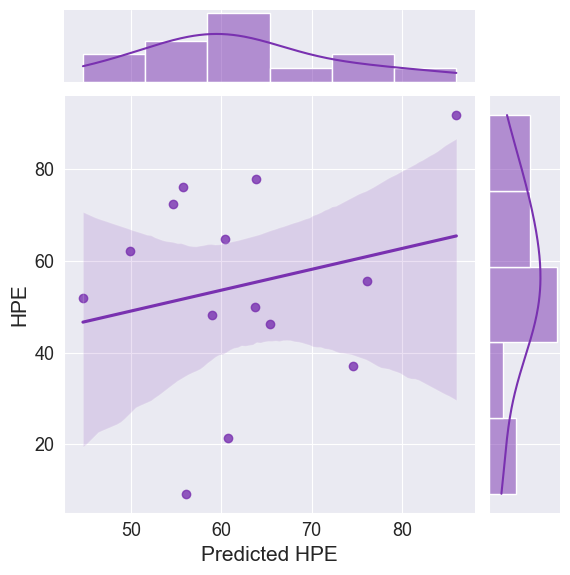

In [17]:
# predict PHE test and plot
df_plot = {'test_label': label_test, 'test_prediction': preds_test}
[label_test, preds_test]
sns.set_style("darkgrid")
plot = sns.jointplot(data=df_plot, x="test_prediction", y="test_label", kind="reg",color='#7931b0',marginal_kws={'color': '#7931b0', 'hist_kws': {'edgecolor': 'black'}})
plt.xlabel('Predicted HPE', fontsize=15)
plt.ylabel('HPE', fontsize=15)
plot.savefig('HPE_test_pred_label_corr_dmpfc.svg',bbox_inches="tight")
slope, intercept, r_value, p_value, std_err = linregress(preds_test, label_test)
print(r_value,p_value)

## XGBoost model using metabolites from the dmPFC to predict kEm

(53,) (18,)
for feat Asp, r = [0.2470915], p = [0.07446737]
for feat GABA, r = [0.13083393], p = [0.35040944]
for feat Gln, r = [0.0666173], p = [0.63553997]
for feat Glu, r = [0.11922257], p = [0.39516082]
for feat GSH, r = [0.13778153], p = [0.32518982]
for feat Gly, r = [-0.09879941], p = [0.48152975]
for feat Ins, r = [0.03952895], p = [0.77869289]
for feat Lac, r = [0.14575252], p = [0.29770566]
for feat NAA, r = [0.01663424], p = [0.90589366]
for feat Glx, r = [0.11935671], p = [0.39462546]
for feat PCr+Cr, r = [0.06653842], p = [0.63594107]
for feat Gln/Glu, r = [0.01500164], p = [0.9150942]
for feat Glu/GABA, r = [-0.07916847], p = [0.57309617]
selected feature by adaboost: [0, 1, 3, 4, 7, 9]
3
['Asp' 'GSH' 'Lac']
>3 -0.856 (0.647)
4
['Asp' 'GABA' 'GSH' 'Lac']
>4 -0.839 (0.619)
5
['Asp' 'GABA' 'GSH' 'Lac' 'Glx']
>5 -0.882 (0.625)
6
['Asp' 'GABA' 'Glu' 'GSH' 'Lac' 'Glx']
>6 -0.879 (0.596)


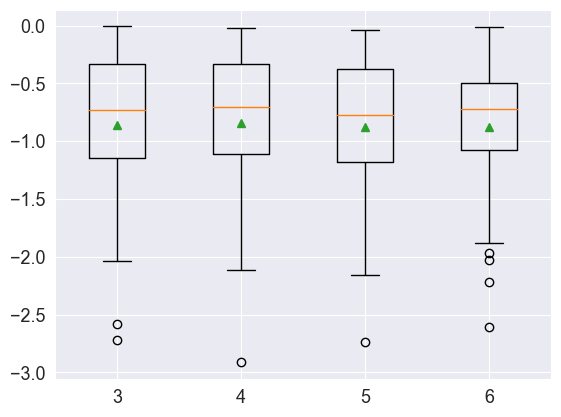

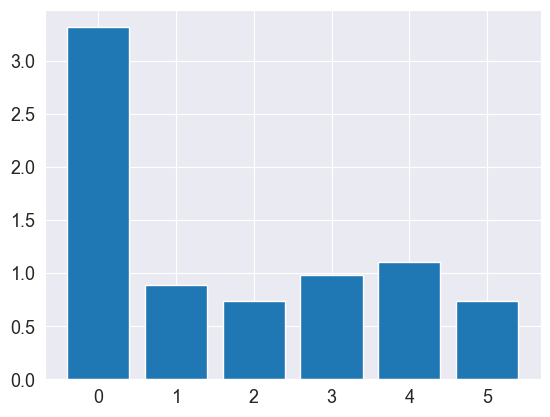

[-0.8559856809104812, -0.839460136662365, -0.8815044808866257, -0.8791273437334506] 4
['Asp' 'GABA' 'GSH' 'Lac']
selected feature by adaboost: [0, 1, 3, 4]
100%|████████████████████████████████████████████████| 10/10 [00:03<00:00,  2.63trial/s, best loss: 0.7575183027183171]

 Optimal selected parameters are : 
 {'eta': 0.018614053949821473, 'max_depth': 38, 'min_child_weight': 0.03744678637601164, 'gamma': 0.01412510474716907, 'lambda': 0.20216810747516178, 'alpha': 0.46326831610903624, 'tree_method': 'exact', 'booster': 'gbtree'} 

[ 0.31789824  1.789566    0.03401236  0.6177974   0.591913   -0.05547391
 -0.01215265  0.9431539   0.6648773  -0.25454316  1.2200305   0.4725627
  0.02405571  0.40168864 -0.12080386  0.6252354   0.5625988   0.9730622 ]
Train RMSE : 0.33874638570764326
Val RMSE : 0.7575183027183171
TRUE RMSE: 0.64232

 r value :  0.4088797653818292 


 R2 value :  0.16718266253869968 


 p value :  0.04601655754468271 

Label range: 4.72612
RMSE Percentage Error: 13.59%

 W

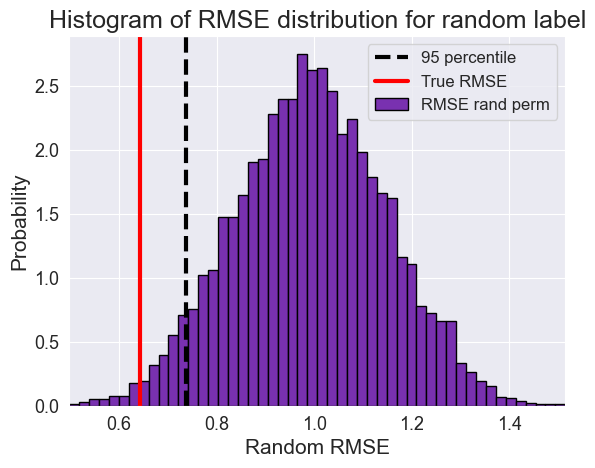


 MODEL ACHIEVED SIGNIFICANCE
 True RMSE: 0.6423164353950377 < 5th percentile: 0.7371284164040213< 95th percentile: 1.2507124002780132|
Correlation between first and second shap score features, r = 0.17556697165330512. p = 0.20858604742704762


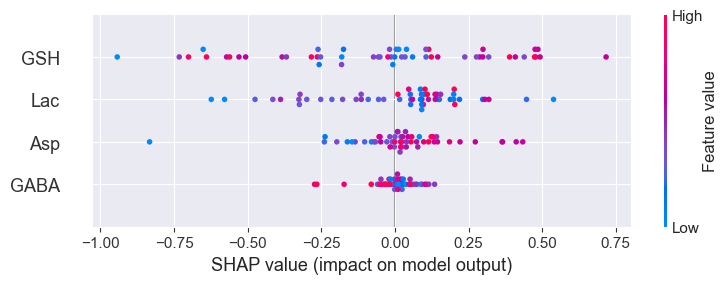

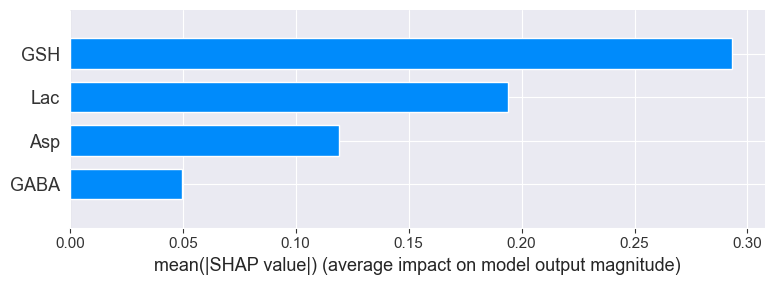

In [18]:
# define parameters range
seed = 0
test_size = 0.25
steps = 100

## initiate dataset and label
label = mod_kEm
data = met_dmpfc_kEm_clean
label_name = 'kEm'
data_names = met_label
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels

# split data into train and test sets
data_train_val, data_test, label_train_val, label_test = train_test_split(data, label, test_size=test_size, random_state=seed)
print(np.shape(label_train_val),np.shape(label_test))
#"""
# first remove any feat with a corr smaller than 0.1
feat_to_keep_wo_low_corr = corr(data_train_val,label_train_val,met_label,label_name)
print("selected feature by adaboost: {}".format(feat_to_keep_wo_low_corr))
data = data[:,feat_to_keep_wo_low_corr]
data_train_val = data_train_val[:,feat_to_keep_wo_low_corr]
data_test = data_test[:,feat_to_keep_wo_low_corr]
data_names = np.array(data_names)[feat_to_keep_wo_low_corr]
nfold_LOO = len(label_train_val)

# next check which feature to keep with adaboost.
selected_feature = feature_selection_CV(data_train_val,label_train_val,feat_names= data_names,k_fold=nfold_LOO,seed=seed)
print("selected feature by adaboost: {}".format(selected_feature))
data = data[:,selected_feature]
data_train_val = data_train_val[:,selected_feature]
data_test = data_test[:,selected_feature]
data_names = np.array(data_names)[selected_feature]
#"""
# prepare xgboost format after feature selection.
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)

# initialize the range to test with hyperopt
space ={'learning_rate' : hp.uniform('x_eta', 0.01,0.3),
        'max_depth': hp.uniform("x_max_depth", 5,50),
        'min_child_weight': hp.uniform ('x_min_child', 0,0.1),
        'gamma' : hp.uniform ('x_gamma',0,0.1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,0.37),
        'reg_alpha' : hp.uniform ('x_reg_alpha', 0,0.5)}



# find optimal hyperparameters through hyperopt extension
best,best_val_RMSE = find_optimal_hyperparam(space,seed)

# initialize optimal param

param = {'eta': best['x_eta'],
          'max_depth': int(best['x_max_depth']),
          'min_child_weight': best['x_min_child'],
          'gamma': best['x_gamma'],
          'lambda': best['x_reg_lambda'],
          'alpha': best['x_reg_alpha'],
          'tree_method' : 'exact',
          'booster': 'gbtree'}

# optimal hyperparameters are:
print("\n Optimal selected parameters are : \n {} \n".format(param), sep = '\n\n')


# quickly train the model with the hole dataset (not CV anymore)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)
model = xgb.train(param,dtrain, steps)
preds_train = np.array(model.predict(dtrain))
preds_test = np.array(model.predict(dtest))
print(preds_test)

# Calculate Train RMSE
print("Train RMSE : {}".format(math.sqrt(np.mean((preds_train - label_train_val) ** 2))))
print("Val RMSE : {}".format(best_val_RMSE))

# Calculate the Root Mean Squared Error
print("TRUE RMSE: %.5f"
      % math.sqrt(np.mean((preds_test - label_test) ** 2)), sep = '\n\n')
TRUERMSE = math.sqrt(np.mean((preds_test - label_test) ** 2))

r_value,p_value = stats.spearmanr(preds_test, label_test,alternative='greater')
print('\n r value : ',r_value,'\n')
print('\n R2 value : ',r_value*r_value,'\n')
print('\n p value : ',p_value,'\n')

print("Label range: %.5f"
        % float(max(label) - min(label)), sep = '\n\n')
label_range = float(max(label) - min(label))

print("RMSE Percentage Error: %.2f" % (100*(TRUERMSE/label_range))+ "%", sep = '\n\n')

# Check if the model is obtained by chance
significance_permutation_test(ML_type ='xgb',param=param,steps=steps,label=label,data=data,TRUERMSE=TRUERMSE,seed=seed,test_size=test_size,plot_save_name='dmpfc_'+label_name,nb_of_permutation=5000)

# look at the most important features
shap_plot(param,label,data,test_size,seed,feat_name=data_names,plot_save_name='dmpfc_'+label_name,nb_of_disp_param=np.size(selected_feature))
# now transform to the original dimension
#lmbda = -0.2170307272489147
#label_test = inv_boxcox(label_test, lmbda)
#preds_test = inv_boxcox(preds_test, lmbda)

0.34779633791034575 0.15728838873990894


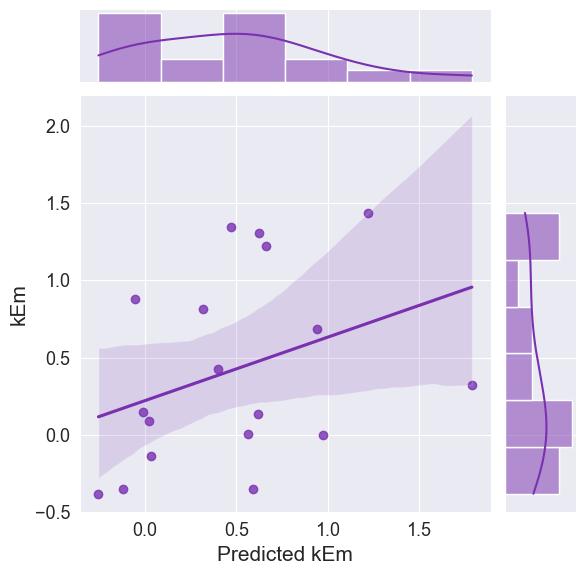

In [19]:
# predict kEm and plot
df_plot = {'test_label': label_test, 'test_prediction': preds_test}
[label_test, preds_test]
sns.set_style("darkgrid")
plot = sns.jointplot(data=df_plot, x="test_prediction", y="test_label", kind="reg",color='#7931b0',marginal_kws={'color': '#7931b0', 'hist_kws': {'edgecolor': 'black'}})
plt.xlabel('Predicted kEm', fontsize=15)
plt.ylabel('kEm', fontsize=15)
plot.savefig('kEm_test_pred_label_corr_dmpfc.svg',bbox_inches="tight")
slope, intercept, r_value, p_value, std_err = linregress(label_test, preds_test)
print(r_value,p_value)

## SCRIPT TO RUN using metabolites in the AI as a source dataset

## XGBoost model using metabolites from the AI to predict MHE

for feat Asp, r = [0.23740913], p = [0.08093606]
for feat GABA, r = [0.10770214], p = [0.43381805]
for feat Gln, r = [0.12665132], p = [0.35683374]
for feat Glu, r = [0.20224924], p = [0.13865446]
for feat GSH, r = [0.13611588], p = [0.32173554]
for feat Gly, r = [-0.12303991], p = [0.37082097]
for feat Ins, r = [2.35950368e-05], p = [0.99986359]
for feat Lac, r = [-0.15476509], p = [0.25922725]
for feat NAA, r = [0.27680671], p = [0.04076943]
for feat Glx, r = [0.2248194], p = [0.09890005]
for feat PCr+Cr, r = [0.18279441], p = [0.18161845]
for feat Gln/Glu, r = [0.00476519], p = [0.97245608]
for feat Glu/GABA, r = [-0.10123015], p = [0.46210117]
selected feature by adaboost: [0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 12]
3
['Asp' 'NAA' 'Glx']
>3 -14.606 (12.800)
4
['Asp' 'Glu' 'NAA' 'Glx']
>4 -14.926 (13.013)
5
['Asp' 'Glu' 'NAA' 'Glx' 'PCr+Cr']
>5 -15.010 (13.222)
6
['Asp' 'Glu' 'Lac' 'NAA' 'Glx' 'PCr+Cr']
>6 -14.718 (12.705)
7
['Asp' 'Glu' 'GSH' 'Lac' 'NAA' 'Glx' 'PCr+Cr']
>7 -14.586 (12.413)

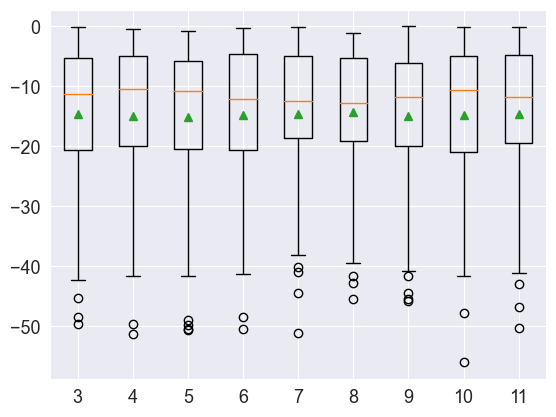

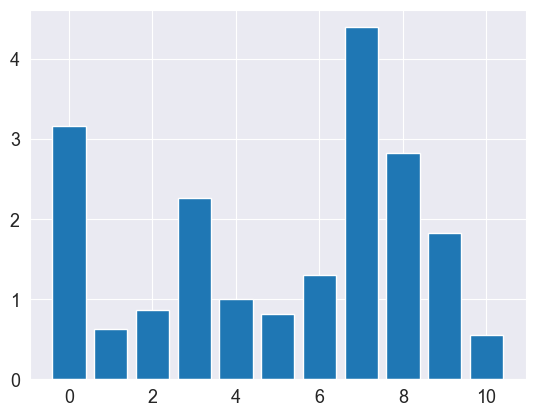

[-14.606401713071932, -14.92556618202423, -15.009566210666335, -14.718217738988299, -14.585960751865974, -14.219593393746718, -14.87322234804621, -14.702471149766664, -14.575335986289891] 8
['Asp' 'Gln' 'Glu' 'GSH' 'Lac' 'NAA' 'Glx' 'PCr+Cr']
selected feature by adaboost: [0, 2, 3, 4, 6, 7, 8, 9]
100%|█████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.26s/trial, best loss: 15.22105935781302]

 Optimal selected parameters are : 
 {'eta': 0.2462554110212993, 'max_depth': 47, 'min_child_weight': 0.009518804446457474, 'gamma': 0.11654855357650301, 'lambda': 0.04882267562727827, 'alpha': 0.054873934287572944, 'tree_method': 'exact', 'booster': 'gbtree'} 

[78.12528  70.01942  79.48712  72.69231  84.88798  66.53595  79.61743
 66.11284  65.32528  74.2555   78.838394 79.32345  73.30377  76.93668 ]
Train RMSE : 0.14031237553070125
Val RMSE : 15.22105935781302
TRUE RMSE: 17.88345

 r value :  -0.40044028631930756 


 R2 value :  0.16035242290748902 


 p value :  0.9220241

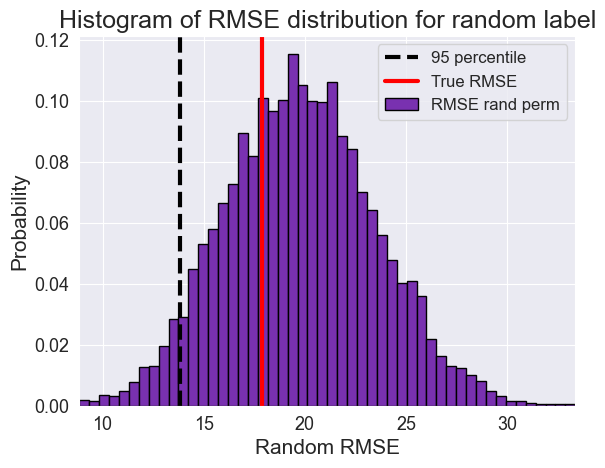


 Model is NOT significant
 5th percentile: 13.814357181835275 < True RMSE: 17.883452552114285 < 95th percentile: 25.909143337654875|
Correlation between first and second shap score features, r = 0.32935959080295196. p = 0.014071680689132187


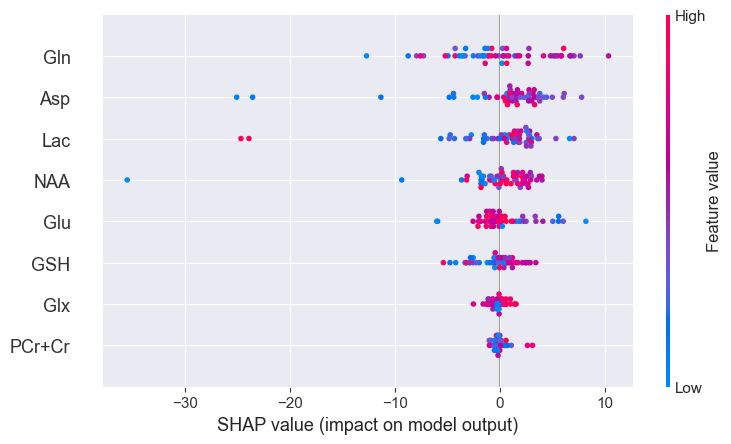

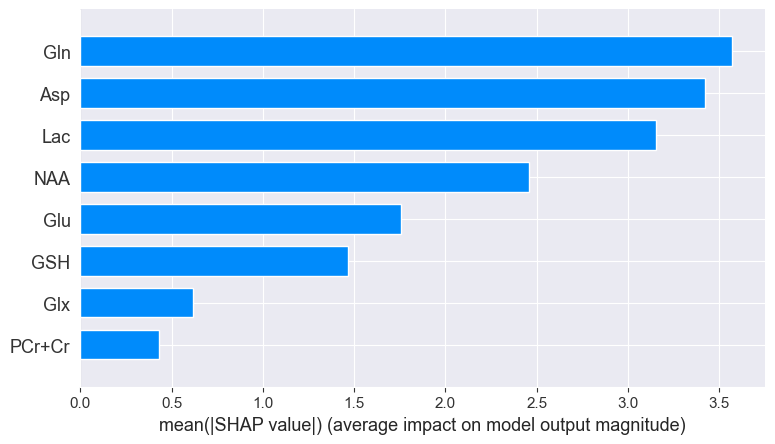

In [24]:
# define parameters range
seed =3
test_size = 0.2
steps = 100

## initiate dataset and label
label = 100*MHE/54
data = met_ai_MHE_clean
label_name = 'MHE'
data_names = met_label
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels

# split data into train and test sets
data_train_val, data_test, label_train_val, label_test = train_test_split(data, label, test_size=test_size, random_state=seed)

# first remove any feat with a corr smaller than 0.1
feat_to_keep_wo_low_corr = corr(data_train_val,label_train_val,met_label,label_name)
print("selected feature by adaboost: {}".format(feat_to_keep_wo_low_corr))
data = data[:,feat_to_keep_wo_low_corr]
data_train_val = data_train_val[:,feat_to_keep_wo_low_corr]
data_test = data_test[:,feat_to_keep_wo_low_corr]
data_names = np.array(data_names)[feat_to_keep_wo_low_corr]
nfold_LOO = len(label_train_val)

# next check which feature to keep with adaboost.
selected_feature = feature_selection_CV(data_train_val,label_train_val,feat_names= data_names,k_fold=nfold_LOO,seed=seed)
print("selected feature by adaboost: {}".format(selected_feature))
data = data[:,selected_feature]
data_train_val = data_train_val[:,selected_feature]
data_test = data_test[:,selected_feature]
data_names = np.array(data_names)[selected_feature]

# prepare xgboost format after feature selection.
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)

# initialize the range to test with hyperopt
space ={'learning_rate' : hp.uniform('x_eta', 0.01,0.3),
        'max_depth': hp.uniform("x_max_depth", 5,50),
        'min_child_weight': hp.uniform ('x_min_child', 0,0.2),
        'gamma' : hp.uniform ('x_gamma',0,0.2),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,0.06),
        'reg_alpha' : hp.uniform ('x_reg_alpha', 0,0.06)}



# find optimal hyperparameters through hyperopt extension
best,best_val_RMSE = find_optimal_hyperparam(space,seed)

# initialize optimal param

param = {'eta': best['x_eta'],
          'max_depth': int(best['x_max_depth']),
          'min_child_weight': best['x_min_child'],
          'gamma': best['x_gamma'],
          'lambda': best['x_reg_lambda'],
          'alpha': best['x_reg_alpha'],
          'tree_method' : 'exact',
          'booster': 'gbtree'}

# optimal hyperparameters are:
print("\n Optimal selected parameters are : \n {} \n".format(param), sep = '\n\n')


# quickly train the model with the hole dataset (not CV anymore)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)
model = xgb.train(param,dtrain, steps)
preds_train = np.array(model.predict(dtrain))
preds_test = np.array(model.predict(dtest))
print(preds_test)

# Calculate Train RMSE
print("Train RMSE : {}".format(math.sqrt(np.mean((preds_train - label_train_val) ** 2))))
print("Val RMSE : {}".format(best_val_RMSE))

# Calculate the Root Mean Squared Error
print("TRUE RMSE: %.5f"
      % math.sqrt(np.mean((preds_test - label_test) ** 2)), sep = '\n\n')
TRUERMSE = math.sqrt(np.mean((preds_test - label_test) ** 2))

r_value,p_value = stats.spearmanr(preds_test, label_test,alternative='greater')
print('\n r value : ',r_value,'\n')
print('\n R2 value : ',r_value*r_value,'\n')
print('\n p value : ',p_value,'\n')

print("Label range: %.5f"
        % float(max(label) - min(label)), sep = '\n\n')
label_range = float(max(label) - min(label))

print("RMSE Percentage Error: %.2f" % (100*(TRUERMSE/label_range))+ "%", sep = '\n\n')

# Check if the model is obtained by chance
significance_permutation_test(ML_type ='xgb',param=param,steps=steps,label=label,data=data,TRUERMSE=TRUERMSE,seed=seed,test_size=test_size,plot_save_name='ai_'+label_name,nb_of_permutation=5000)

# look at the most important features
shap_plot(param,label,data,test_size,seed,feat_name=data_names,plot_save_name='ai_'+label_name,nb_of_disp_param=np.size(selected_feature))

-0.3559078362107296 0.211692610738058


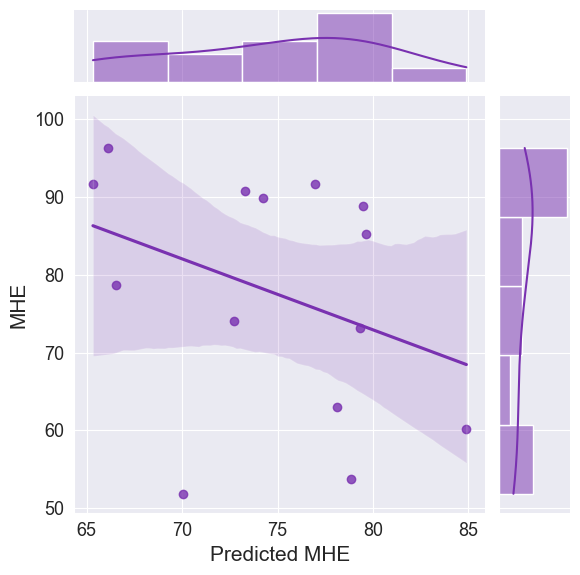

In [25]:
# predict MHE test and plot
df_plot = {'test_label': label_test, 'test_prediction': preds_test}
[label_test, preds_test]
sns.set_style("darkgrid")
plot = sns.jointplot(data=df_plot, x="test_prediction", y="test_label", kind="reg",color='#7931b0',marginal_kws={'color': '#7931b0', 'hist_kws': {'edgecolor': 'black'}})
plt.xlabel('Predicted MHE', fontsize=15)
plt.ylabel('MHE', fontsize=15)
plot.savefig('MHE_test_pred_label_corr_AI.svg',bbox_inches="tight")
slope, intercept, r_value, p_value, std_err = linregress(preds_test, label_test)
print(r_value,p_value)

## XGBoost model using metabolites from the dmPFC to predict PHE

In [ ]:
# define parameters range
seed =3
test_size = 0.2
steps = 100

## initiate dataset and label
label = 100*PHE/54
data = met_ai_PHE_clean
label_name = 'PHE'
data_names = met_label
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels

# split data into train and test sets
data_train_val, data_test, label_train_val, label_test = train_test_split(data, label, test_size=test_size, random_state=seed)

# first remove any feat with a corr smaller than 0.1
feat_to_keep_wo_low_corr = corr(data_train_val,label_train_val,met_label,label_name)
print("selected feature by adaboost: {}".format(feat_to_keep_wo_low_corr))
data = data[:,feat_to_keep_wo_low_corr]
data_train_val = data_train_val[:,feat_to_keep_wo_low_corr]
data_test = data_test[:,feat_to_keep_wo_low_corr]
data_names = np.array(data_names)[feat_to_keep_wo_low_corr]
nfold_LOO = len(label_train_val)

# next check which feature to keep with adaboost.
selected_feature = feature_selection_CV(data_train_val,label_train_val,feat_names= data_names,k_fold=nfold_LOO,seed=seed)
print("selected feature by adaboost: {}".format(selected_feature))
data = data[:,selected_feature]
data_train_val = data_train_val[:,selected_feature]
data_test = data_test[:,selected_feature]
data_names = np.array(data_names)[selected_feature]

# prepare xgboost format after feature selection.
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)

# initialize the range to test with hyperopt
space ={'learning_rate' : hp.uniform('x_eta', 0.01,0.3),
        'max_depth': hp.uniform("x_max_depth", 5,50),
        'min_child_weight': hp.uniform ('x_min_child', 0,0.2),
        'gamma' : hp.uniform ('x_gamma',0,0.2),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,0.06),
        'reg_alpha' : hp.uniform ('x_reg_alpha', 0,0.06)}



# find optimal hyperparameters through hyperopt extension
best,best_val_RMSE = find_optimal_hyperparam(space,seed)

# initialize optimal param

param = {'eta': best['x_eta'],
          'max_depth': int(best['x_max_depth']),
          'min_child_weight': best['x_min_child'],
          'gamma': best['x_gamma'],
          'lambda': best['x_reg_lambda'],
          'alpha': best['x_reg_alpha'],
          'tree_method' : 'exact',
          'booster': 'gbtree'}

# optimal hyperparameters are:
print("\n Optimal selected parameters are : \n {} \n".format(param), sep = '\n\n')


# quickly train the model with the hole dataset (not CV anymore)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)
model = xgb.train(param,dtrain, steps)
preds_train = np.array(model.predict(dtrain))
preds_test = np.array(model.predict(dtest))
print(preds_test)

# Calculate Train RMSE
print("Train RMSE : {}".format(math.sqrt(np.mean((preds_train - label_train_val) ** 2))))
print("Val RMSE : {}".format(best_val_RMSE))

# Calculate the Root Mean Squared Error
print("TRUE RMSE: %.5f"
      % math.sqrt(np.mean((preds_test - label_test) ** 2)), sep = '\n\n')
TRUERMSE = math.sqrt(np.mean((preds_test - label_test) ** 2))

r_value,p_value = stats.spearmanr(preds_test, label_test,alternative='greater')
print('\n r value : ',r_value,'\n')
print('\n R2 value : ',r_value*r_value,'\n')
print('\n p value : ',p_value,'\n')

print("Label range: %.5f"
        % float(max(label) - min(label)), sep = '\n\n')
label_range = float(max(label) - min(label))

print("RMSE Percentage Error: %.2f" % (100*(TRUERMSE/label_range))+ "%", sep = '\n\n')

# Check if the model is obtained by chance
significance_permutation_test(ML_type ='xgb',param=param,steps=steps,label=label,data=data,TRUERMSE=TRUERMSE,seed=seed,test_size=test_size,plot_save_name='ai_'+label_name,nb_of_permutation=5000)

# look at the most important features
shap_plot(param,label,data,test_size,seed,feat_name=data_names,plot_save_name='ai_'+label_name,nb_of_disp_param=np.size(selected_feature))

In [ ]:
# predict PHE test and plot
df_plot = {'test_label': label_test, 'test_prediction': preds_test}
[label_test, preds_test]
sns.set_style("darkgrid")
plot = sns.jointplot(data=df_plot, x="test_prediction", y="test_label", kind="reg",color='#7931b0',marginal_kws={'color': '#7931b0', 'hist_kws': {'edgecolor': 'black'}})
plt.xlabel('Predicted PHE', fontsize=15)
plt.ylabel('PHE', fontsize=15)
plot.savefig('PHE_test_pred_label_corr_AI.svg',bbox_inches="tight")
slope, intercept, r_value, p_value, std_err = linregress(preds_test, label_test)
print(r_value,p_value)

## XGBoost model using metabolites from the AI to predict kEm

for feat Asp, r = [0.0909067], p = [0.51739108]
for feat GABA, r = [0.1989791], p = [0.15318381]
for feat Gln, r = [-0.09354431], p = [0.50525952]
for feat Glu, r = [0.0281455], p = [0.84143684]
for feat GSH, r = [-0.20094606], p = [0.1490798]
for feat Gly, r = [0.18650821], p = [0.18116043]
for feat Ins, r = [0.1277191], p = [0.36209643]
for feat Lac, r = [0.24743412], p = [0.07405324]
for feat NAA, r = [0.03170921], p = [0.82166921]
for feat Glx, r = [-0.01411989], p = [0.92006793]
for feat PCr+Cr, r = [-0.07894686], p = [0.57417382]
for feat Gln/Glu, r = [-0.13747926], p = [0.3262626]
for feat Glu/GABA, r = [-0.14487352], p = [0.30066027]
selected feature by adaboost: [1, 4, 5, 6, 7, 11, 12]
3
['GABA' 'GSH' 'Lac']
>3 -0.853 (0.739)
4
['GABA' 'GSH' 'Gly' 'Lac']
>4 -0.792 (0.673)
5
['GABA' 'GSH' 'Gly' 'Lac' 'Glu/GABA']
>5 -0.780 (0.612)
6
['GABA' 'GSH' 'Gly' 'Lac' 'Gln/Glu' 'Glu/GABA']
>6 -0.720 (0.586)
7
['GABA' 'GSH' 'Gly' 'Ins' 'Lac' 'Gln/Glu' 'Glu/GABA']
>7 -0.682 (0.551)


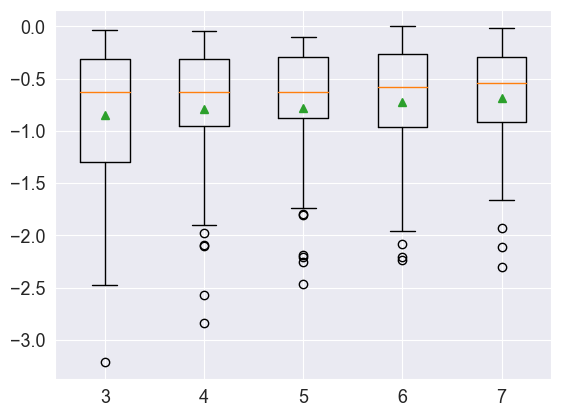

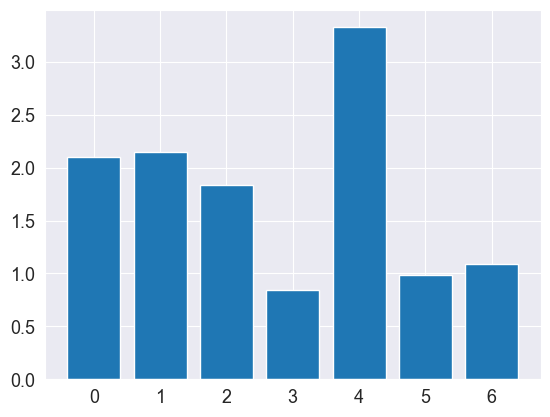

[-0.8526897514363894, -0.7918624383757673, -0.7800557347812825, -0.7200298373333393, -0.6822862028519094] 7
['GABA' 'GSH' 'Gly' 'Ins' 'Lac' 'Gln/Glu' 'Glu/GABA']
selected feature by adaboost: [0, 1, 2, 3, 4, 5, 6]
100%|████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.85trial/s, best loss: 0.7289979383248858]

 Optimal selected parameters are : 
 {'eta': 0.20792633223489596, 'max_depth': 25, 'min_child_weight': 0.22410449201998706, 'gamma': 0.005330433384098887, 'lambda': 0.454663135591284, 'alpha': 0.23617571361001455, 'tree_method': 'exact', 'booster': 'gbtree'} 

[ 0.77257216  0.29455984  0.3447158  -0.65392274  1.1586747   1.855757
  0.01968531  0.1280689   0.28196958  1.0276082   1.2852117   0.46798113
  2.1550736   0.37745246  0.45651707  0.13159955  0.08573262 -0.00984997]
Train RMSE : 0.07214854582253002
Val RMSE : 0.7289979383248858
TRUE RMSE: 0.89338

 r value :  0.07330925086391384 


 R2 value :  0.005374246262228251 


 p value :  0.38625823944025695

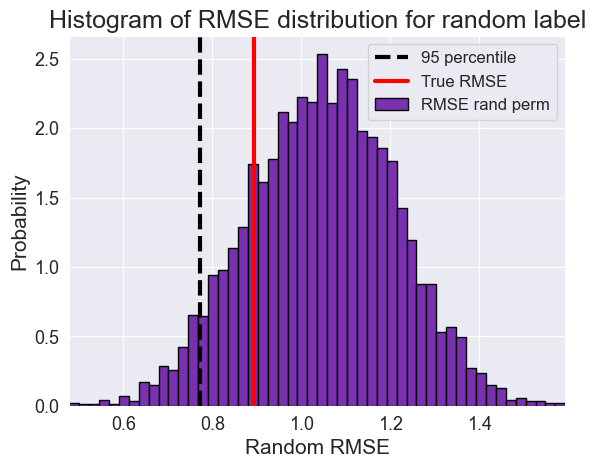


 Model is NOT significant
 5th percentile: 0.7712471661897429 < True RMSE: 0.8933785326764181 < 95th percentile: 1.318418848478665|
Correlation between first and second shap score features, r = 0.23485538021239735. p = 0.09049923992561973


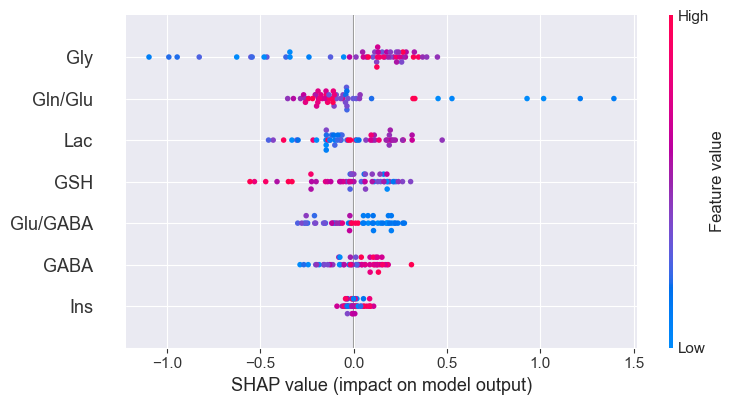

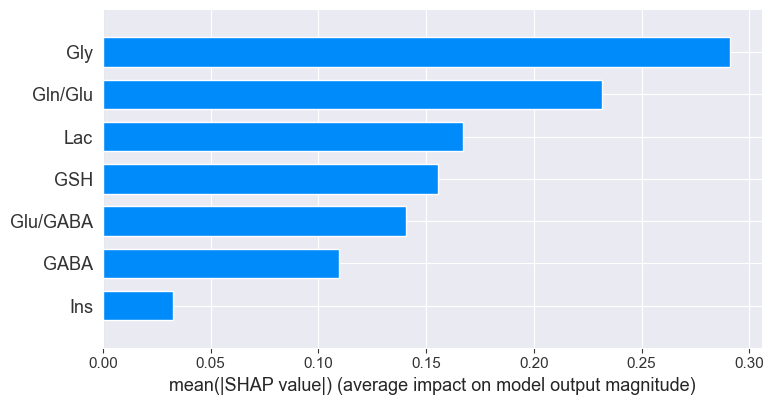

In [26]:
# define parameters range
seed = 0
test_size = 0.25
steps = 100

## initiate dataset and label
label = mod_kEm
data = met_ai_kEm_clean
label_name = 'kEm'
data_names = met_label
plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels

# split data into train and test sets
data_train_val, data_test, label_train_val, label_test = train_test_split(data, label, test_size=test_size, random_state=seed)

# first remove any feat with a corr smaller than 0.1
feat_to_keep_wo_low_corr = corr(data_train_val,label_train_val,met_label,label_name)
print("selected feature by adaboost: {}".format(feat_to_keep_wo_low_corr))
data = data[:,feat_to_keep_wo_low_corr]
data_train_val = data_train_val[:,feat_to_keep_wo_low_corr]
data_test = data_test[:,feat_to_keep_wo_low_corr]
data_names = np.array(data_names)[feat_to_keep_wo_low_corr]
nfold_LOO = len(label_train_val)

# next check which feature to keep with adaboost.
selected_feature = feature_selection_CV(data_train_val,label_train_val,feat_names= data_names,k_fold=nfold_LOO,seed=seed)
print("selected feature by adaboost: {}".format(selected_feature))
data = data[:,selected_feature]
data_train_val = data_train_val[:,selected_feature]
data_test = data_test[:,selected_feature]
data_names = np.array(data_names)[selected_feature]

# prepare xgboost format after feature selection.
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)

# initialize the range to test with hyperopt
space ={'learning_rate' : hp.uniform('x_eta', 0.01,0.3),
        'max_depth': hp.uniform("x_max_depth", 5,50),
        'min_child_weight': hp.uniform ('x_min_child', 0,0.25),
        'gamma' : hp.uniform ('x_gamma',0,1),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,0.5),
        'reg_alpha' : hp.uniform ('x_reg_alpha', 0,0.75)}



# find optimal hyperparameters through hyperopt extension
best,best_val_RMSE = find_optimal_hyperparam(space,seed)

# initialize optimal param

param = {'eta': best['x_eta'],
          'max_depth': int(best['x_max_depth']),
          'min_child_weight': best['x_min_child'],
          'gamma': best['x_gamma'],
          'lambda': best['x_reg_lambda'],
          'alpha': best['x_reg_alpha'],
          'tree_method' : 'exact',
          'booster': 'gbtree'}

# optimal hyperparameters are:
print("\n Optimal selected parameters are : \n {} \n".format(param), sep = '\n\n')


# quickly train the model with the hole dataset (not CV anymore)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)
model = xgb.train(param,dtrain, steps)
preds_train = np.array(model.predict(dtrain))
preds_test = np.array(model.predict(dtest))
print(preds_test)

# Calculate Train RMSE
print("Train RMSE : {}".format(math.sqrt(np.mean((preds_train - label_train_val) ** 2))))
print("Val RMSE : {}".format(best_val_RMSE))

# Calculate the Root Mean Squared Error
print("TRUE RMSE: %.5f"
      % math.sqrt(np.mean((preds_test - label_test) ** 2)), sep = '\n\n')
TRUERMSE = math.sqrt(np.mean((preds_test - label_test) ** 2))

r_value,p_value = stats.spearmanr(preds_test, label_test,alternative='greater')
print('\n r value : ',r_value,'\n')
print('\n R2 value : ',r_value*r_value,'\n')
print('\n p value : ',p_value,'\n')

print("Label range: %.5f"
        % float(max(label) - min(label)), sep = '\n\n')
label_range = float(max(label) - min(label))

print("RMSE Percentage Error: %.2f" % (100*(TRUERMSE/label_range))+ "%", sep = '\n\n')

# Check if the model is obtained by chance
significance_permutation_test(ML_type ='xgb',param=param,steps=steps,label=label,data=data,TRUERMSE=TRUERMSE,seed=seed,test_size=test_size,plot_save_name='ai_'+label_name,nb_of_permutation=5000)

# look at the most important features
shap_plot(param,label,data,test_size,seed,feat_name=data_names,plot_save_name='ai_'+label_name,nb_of_disp_param=np.size(selected_feature))

0.05502220555430092 0.8283299190031348


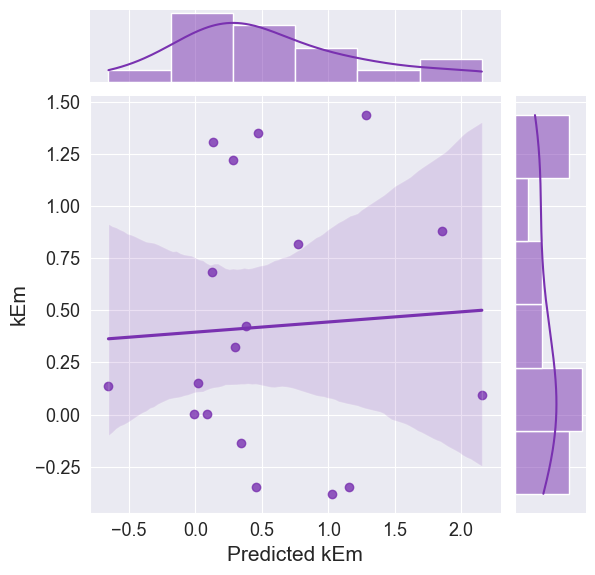

In [27]:
# predict Kem test and plot
df_plot = {'test_label': label_test, 'test_prediction': preds_test}
[label_test, preds_test]
sns.set_style("darkgrid")
plot = sns.jointplot(data=df_plot, x="test_prediction", y="test_label", kind="reg",color='#7931b0',marginal_kws={'color': '#7931b0', 'hist_kws': {'edgecolor': 'black'}})
plt.xlabel('Predicted kEm', fontsize=15)
plt.ylabel('kEm', fontsize=15)
plot.savefig('kEm_test_pred_label_corr_AI.svg',bbox_inches="tight")
slope, intercept, r_value, p_value, std_err = linregress(preds_test, label_test)
print(r_value,p_value)

# Feature selection: test models using a combination of Lactate,  Aspartate and Glutamate

In [28]:
# Prepare datasets
df_dmpfc = pd.read_excel('D:\python_work\python_exp1\datasets\met_dmpfc_imputed.xlsx', index_col=None,header=None)  
met_dmpfc = df_dmpfc.values
# select aspartate glutamate lactate
met_dmpfc = np.concatenate([met_dmpfc[:,0:1],met_dmpfc[:,3:4],met_dmpfc[:,7:8]],axis = 1)

met_label =['Asp','Glu','Lac']

# a variable required for the pipeline to work. Here we choose our features, so we create it manually.
selected_feature = [0,1,2]


# find and remove data where there is no label measures
missing_data_PHE_idx = np.isnan(perf[:,2])
missing_data_MHE_idx = np.isnan(perf[:,3])

# select datasets where we have data only
met_dmpfc_MHE_clean = np.delete(met_dmpfc,missing_data_MHE_idx, axis=0)
met_dmpfc_PHE_clean = np.delete(met_dmpfc,missing_data_PHE_idx, axis=0)
met_ai_MHE_clean = np.delete(met_ai,missing_data_MHE_idx, axis=0)
met_ai_PHE_clean = np.delete(met_ai,missing_data_PHE_idx, axis=0)
PHE = np.delete(perf[:,2],missing_data_PHE_idx, axis=0)
MHE = np.delete(perf[:,3],missing_data_MHE_idx, axis=0)

# zscore data
met_dmpfc_MHE_clean =  stats.zscore(met_dmpfc_MHE_clean,axis=0, ddof=1)
met_dmpfc_PHE_clean =  stats.zscore(met_dmpfc_PHE_clean,axis=0, ddof=1)
met_ai_MHE_clean =  stats.zscore(met_ai_MHE_clean,axis=0, ddof=1)
met_ai_PHE_clean =  stats.zscore(met_ai_PHE_clean,axis=0, ddof=1)

## XGBoost model using Lactate, Aspartate, Glutamate from the dmPFC to predict MHE

100%|█████████████████████████████████████████████████| 10/10 [00:36<00:00,  3.64s/trial, best loss: 15.68516175208026]

 Optimal selected parameters are : 
 {'eta': 0.04982863845280223, 'max_depth': 6, 'min_child_weight': 0.10515100995670826, 'gamma': 0.14428874377140596, 'lambda': 0.019554596555170722, 'alpha': 0.07299511573300946, 'tree_method': 'exact', 'booster': 'gbtree'} 

[71.63037  54.06125  70.970055 59.216274 63.252613 79.74349  84.56038
 91.6667   80.1034   65.199974 72.849014 67.845245 78.78512  74.916466]
Train RMSE : 0.7535996092804501
Val RMSE : 15.68516175208026
TRUE RMSE: 12.56960

 R value :  0.6468650779004199 


 p value :  0.006204866004578373 

Label range: 67.59259
RMSE Percentage Error: 18.60%

 Will now run permutation test, to check for significance, please wait:
running permutation number : 1000, out of 5000
running permutation number : 2000, out of 5000
running permutation number : 3000, out of 5000
running permutation number : 4000, out of 5000


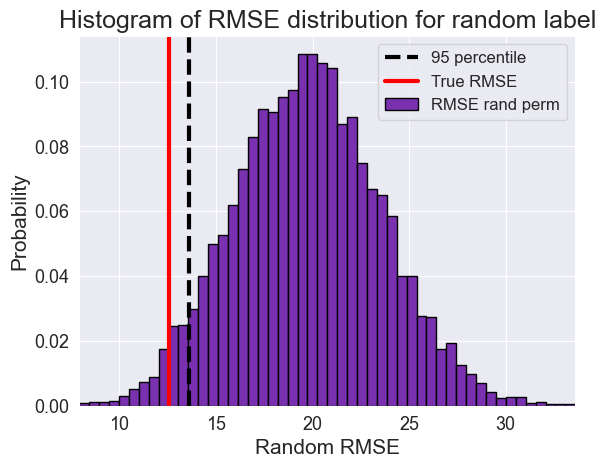


 MODEL ACHIEVED SIGNIFICANCE
 True RMSE: 12.569598711204849 < 5th percentile: 13.592369720624875< 95th percentile: 26.13011054856217|
Correlation between first and second shap score features, r = 0.4869345405412793. p = 0.00016332212371305012


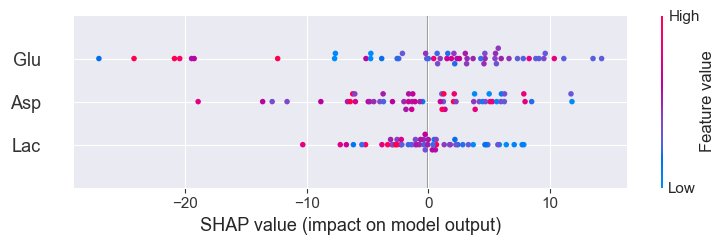

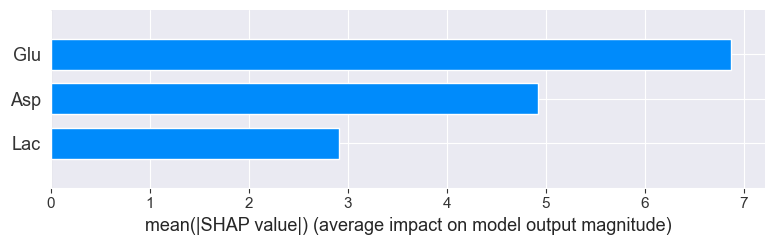

In [29]:
# define parameters range
seed =3
test_size = 0.2
steps = 100

## initiate dataset and label
label = 100*MHE/54
data = met_dmpfc_MHE_clean
label_name = 'MHE'
data_names = met_label

plt.rc('legend', fontsize=12)    # legend fontsize
plt.rc('font', size=15)          # controls default text sizes
plt.rc('xtick', labelsize=13)    # fontsize of the tick labels
plt.rc('ytick', labelsize=13)    # fontsize of the tick labels

# split data into train and test sets
data_train_val, data_test, label_train_val, label_test = train_test_split(data, label, test_size=test_size, random_state=seed)
nfold_LOO = len(label_train_val)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)

space ={'learning_rate' : hp.uniform('x_eta', 0.01,0.3),
        'max_depth': hp.uniform("x_max_depth", 5,50),
        'min_child_weight': hp.uniform ('x_min_child', 0,0.2),
        'gamma' : hp.uniform ('x_gamma',0,0.8),
        'reg_lambda' : hp.uniform ('x_reg_lambda', 0,0.1),
        'reg_alpha' : hp.uniform ('x_reg_alpha', 0,0.1)}


# find optimal hyperparameters through hyperopt extension
best,best_val_RMSE = find_optimal_hyperparam(space,seed)

# initialize optimal param

param = {'eta': best['x_eta'],
          'max_depth': int(best['x_max_depth']),
          'min_child_weight': best['x_min_child'],
          'gamma': best['x_gamma'],
          'lambda': best['x_reg_lambda'],
          'alpha': best['x_reg_alpha'],
          'tree_method' : 'exact',
          'booster': 'gbtree'}

# optimal hyperparameters are:
print("\n Optimal selected parameters are : \n {} \n".format(param), sep = '\n\n')


# quickly train the model with the hole dataset (not CV anymore)
dtrain = xgb.DMatrix(data_train_val, label=label_train_val)
dtest = xgb.DMatrix(data_test, label=label_test)
model = xgb.train(param,dtrain, steps)
preds_train = np.array(model.predict(dtrain))
preds_test = np.array(model.predict(dtest))
print(preds_test)

# Calculate Train RMSE
print("Train RMSE : {}".format(math.sqrt(np.mean((preds_train - label_train_val) ** 2))))
print("Val RMSE : {}".format(best_val_RMSE))

# Calculate the Root Mean Squared Error
print("TRUE RMSE: %.5f"
      % math.sqrt(np.mean((preds_test - label_test) ** 2)), sep = '\n\n')
TRUERMSE = math.sqrt(np.mean((preds_test - label_test) ** 2))

r_value,p_value = stats.spearmanr(preds_test, label_test,alternative='greater')
print('\n R value : ',r_value,'\n')
print('\n p value : ',p_value,'\n')

print("Label range: %.5f"
        % float(max(label) - min(label)), sep = '\n\n')
label_range = float(max(label) - min(label))

print("RMSE Percentage Error: %.2f" % (100*(TRUERMSE/label_range))+ "%", sep = '\n\n')

# Check if the model is obtained by chance
significance_permutation_test(ML_type ='xgb',param=param,steps=steps,label=label,data=data,TRUERMSE=TRUERMSE,seed=seed,test_size=test_size,plot_save_name='MHE_lac_asp_glu',nb_of_permutation=5000)

# look at the most important features
shap_plot(param,label,data,test_size,seed,feat_name=data_names,plot_save_name='MHE_lac_asp_glu',nb_of_disp_param=np.size(selected_feature))

0.6338559088880056 0.014927484142594963


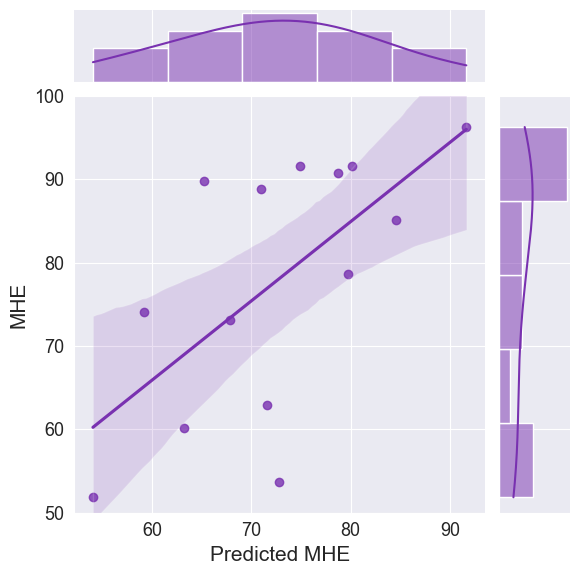

In [30]:
df_plot = {'test_label': label_test, 'test_prediction': preds_test}
[label_test, preds_test]
sns.set_style("darkgrid")
plot = sns.jointplot(data=df_plot, x="test_prediction", y="test_label", kind="reg",color='#7931b0',marginal_kws={'color': '#7931b0', 'hist_kws': {'edgecolor': 'black'}})
plt.xlabel('Predicted MHE', fontsize=15)
plt.ylabel('MHE', fontsize=15)
plt.ylim(bottom = 50 ,top = 100)
plot.savefig('MHE_lac_asp_glu_test_pred_label_corr_dmpfc.svg',bbox_inches="tight")
slope, intercept, r_value, p_value, std_err = linregress(preds_test, label_test)
print(r_value,p_value)